In [1]:
DATASET_PATH = "MNIST"

DEBUG = False

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans #, MiniBatchKMeans
from sklearn import svm
# from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb
from tqdm.notebook import tqdm




In [3]:
class Patchify(nn.Module):
    def __init__(self, patch_size) -> None:
        super(Patchify, self).__init__()
        self.patch_size = patch_size
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        bs, c, h, w = x.shape
        
        assert c == 1, "Input must be a single channel image"
        assert h == w, "Input must be a square image"
        assert h % self.patch_size == 0, "Height must be divisible by patch size"
        
        x = self.unfold(x)
        
        x = x.view(bs, c, self.patch_size, self.patch_size, -1).permute(0, 4, 1, 2, 3)
        
        return x

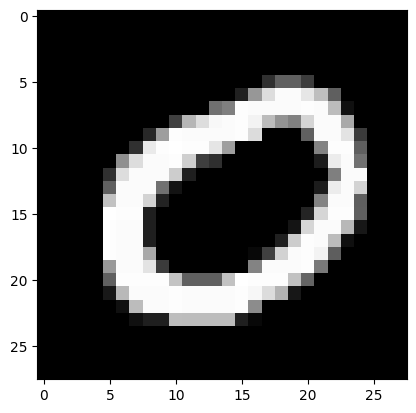

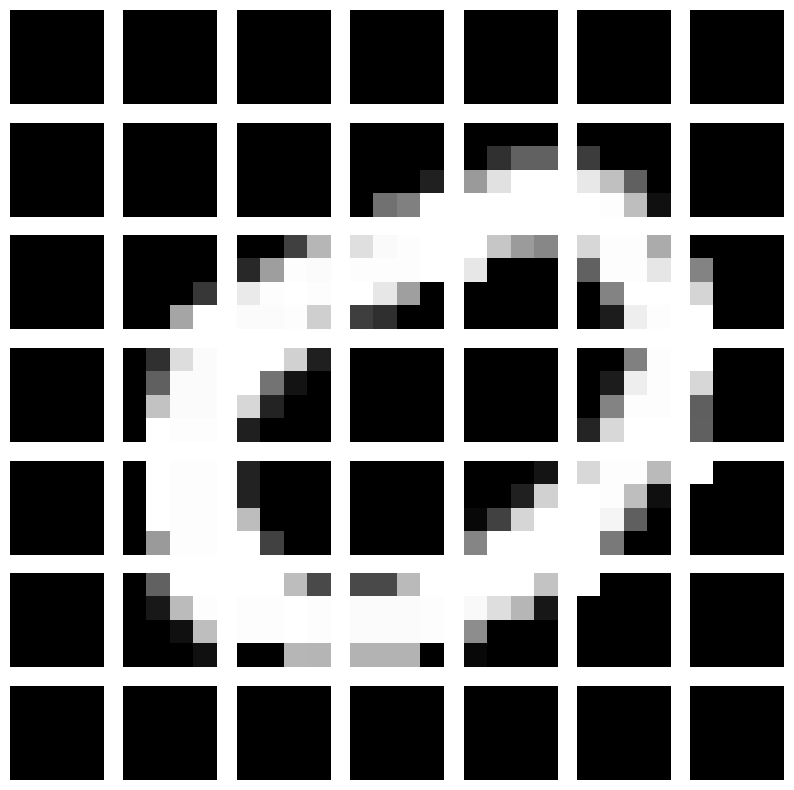

In [12]:
mnist = datasets.MNIST(DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
mnist_loader = DataLoader(mnist, batch_size=1, shuffle=True)

for images, labels in mnist_loader:
    
    # plot the original image
    plt.imshow(images[0, 0].squeeze(), cmap="gray")
    plt.show()
    
    patchfify = Patchify(4)
    
    with torch.no_grad():
        patches = patchfify(images)
    
    
    # calculate the number of patches
    n_patches = patches.shape[1]
    
    # calculate the number of rows and columns for the subplots
    n_rows = int(np.sqrt(n_patches))
    n_cols = n_patches // n_rows
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    
        # reduce the gap between subplots
    # plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(patches[0, i * n_cols + j, 0].squeeze(), cmap="gray")
            ax[i, j].axis("off")
    plt.show()
    break





In [4]:
class ViT(nn.Module):
    def __init__(self, patch_size, hidden_dim, num_classes, heads, mlp_dim, depth, n_patches, dropout, channels = 1) -> None:
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.depth = depth
        self.n_patches = n_patches
        self.channels = channels
        self.dropout = dropout
        
        self.Patcher = Patchify(self.patch_size)
        
        
        
        # Linear transformation for the patches
        self.linear_projection = nn.Linear(self.patch_size * self.patch_size * self.channels, hidden_dim)
        
        self.class_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
                                                                # plus 1 for the class token
        self.positional_embedding = nn.Parameter(torch.randn(1, n_patches + 1, hidden_dim))
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.hidden_dim,
                nhead=self.heads,
                dim_feedforward=self.mlp_dim,
                dropout=self.dropout,
                batch_first=True
            ),
            num_layers=depth
        )
        
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        
        
    def forward(self, images):
        
        patches = self.Patcher(images)
        
       
        bs, n_patches = patches.shape[:2]
        
        patches = patches.view(bs, n_patches, -1)
        
        tokens = self.linear_projection(patches)
        
        class_tokens = self.class_token.repeat(bs, 1, 1)
        
        tokens = torch.cat([class_tokens, tokens], dim=1)
        
        tokens += self.positional_embedding[:, :(n_patches + 1)]
        
        encoded_tokens = self.transformer(tokens)
        
        class_token_output = encoded_tokens[:, 0]
        
        output = self.fc(class_token_output)
        
        return output

In [5]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_set = datasets.MNIST(DATASET_PATH, train=True, download=True, transform=transform)
    test_set = datasets.MNIST(DATASET_PATH, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    return train_loader, test_loader

def get_optimizer(opt, model, learning_rate)-> optim.Optimizer:
    if opt == "adam":
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif opt == "sgd":
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif opt == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif opt == "adagrad":
        return optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer")

def init_model_and_opt(device, optimizer, lr, patch_size, hidden_dim, num_classes, heads, mlp_dim, depth, n_patches, dropout, channels):
    model = ViT(patch_size, hidden_dim, num_classes, heads, mlp_dim, depth, n_patches, dropout, channels).to(device)
    optimizer = get_optimizer(optimizer, model, lr)
    
    return model, optimizer

def train(model, optimizer, train_loader, device, epoch):
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    train_loss = 0
    correct = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        
        train_loss+=loss.item()
        
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)


    print(f"Epoch: {epoch + 1}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return train_loss, accuracy

def test(model, device, test_loader, epoch):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0

    with torch.inference_mode():
        for images, labels in tqdm(test_loader, desc = "Testing"):
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            
            loss = criterion(output, labels)
            
            test_loss += loss.item()
            
            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(labels.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f} \n")
    
    return test_loss, accuracy

def plot_metrics(train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, title):

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    ax[0, 0].plot(train_loss_list, label="Train Loss")
    ax[0, 0].set_title("Train Loss")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].legend()

    ax[0, 1].plot(test_loss_list, label="Test Loss")
    ax[0, 1].set_title("Test Loss")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Loss")
    ax[0, 1].legend()

    ax[1, 0].plot(train_accuracy_list, label="Train Accuracy")
    ax[1, 0].set_title("Train Accuracy")
    ax[1, 0].set_xlabel("Epochs")
    ax[1, 0].set_ylabel("Accuracy")
    ax[1, 0].legend()

    ax[1, 1].plot(test_accuracy_list, label="Test Accuracy")
    ax[1, 1].set_title("Test Accuracy")
    ax[1, 1].set_xlabel("Epochs")
    ax[1, 1].set_ylabel("Accuracy")
    ax[1, 1].legend()

    plt.show()



In [10]:
def main():
    # Loading data
    train_loader, test_loader = load_data()
    
    # get height and width of the images
    HEIGHT, WIDTH = train_loader.dataset.data.shape[1:]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    
    patch_size = 4
    hidden_dim = 256
    num_classes = 10
    heads = 8
    mlp_dim = 512
    depth = 2
    n_patches = (HEIGHT // patch_size) ** 2
    channels = 1
    dropout = 0.1
    lr = 0.001
    
    model, optimizer = init_model_and_opt(device, "adam", lr, patch_size, hidden_dim, num_classes, heads, mlp_dim, depth, n_patches, dropout, channels)
    
    # Number of epochs
    epochs = 5

    # Training and testing the model
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, optimizer, train_loader, device, epoch)
        test_loss, test_accuracy = test(model, device, test_loader, epoch)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, "ViT Model with MNIST Dataset, Adam Optimizer, Learning Rate = 0.001, 5 Epochs, Patch Size = 4, Hidden Dim = 256, Heads = 8, MLP Dim = 512, Depth = 6, Dropout = 0.1, Channels = 1")
    

In [ ]:
main()

# Faizal Implementation


In [ ]:
class VIT(nn.Module):
    def __init__(self,
                 patch_size,
                 input_dim, 
                 heads, 
                 mlp_dim, 
                 dropout, 
                 depth,
                 num_patches):
        
        super().__init__()
        self.input_dim = input_dim
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout 
        self.depth = depth  
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        dim = 256
        
        self.patch_embedding = nn.Conv2d(1, dim, kernel_size=self.patch_size, stride=self.patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, dim))
        
        self.encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.input_dim,
                    nhead=self.heads,
                    dim_feedforward=self.mlp_dim,
                    dropout=self.dropout
                ),
                num_layers=self.depth
            )
        
        self.fc1 = nn.Linear(self.input_dim, 10)
        
    def forward(self, x):
        # x: bs, 1, 28, 28
        
        x = self.patch_embedding(x) # bs, 256, 7, 7
        x = x.flatten(2).transpose(1, 2) # bs, 49, 256
        
        x = x + self.positional_embedding # bs, 49, 256
        
        x = self.encoder(x) # bs, 49, 256
        x = x.mean(dim=1) # bs, 256
        
        x = self.fc1(x) # bs, 10
        
        return x
                

In [ ]:
image_size = 28
patch_size = 4
num_classes = 10
input_dim = 256
depth = 4
heads = 4
mlp_dim = 256
dropout = 0.2
num_patches = int((image_size * image_size)/(patch_size * patch_size))

In [ ]:
model = VIT(patch_size,
            input_dim, 
            heads, 
            mlp_dim, 
            dropout, 
            depth,
            num_patches)